In [1]:

from pyspark.sql import SparkSession
from config import get_logger
from utils.data_extractor import fetch_movies_from_api
from utils.transform import clean_movie_data
from utils.data_analysis import search_movies, rank_movies, get_successful_directors, get_successful_franchises, analyze_franchise_vs_standalone
from utils.visualizations import plot_revenue_vs_budget, plot_franchise_comparison, plot_popularity_vs_rating, plot_roi_by_genre, plot_yearly_trends


In [2]:
import os
os.environ['SPARK_HOME'] = '/opt/spark'
os.environ['PYSPARK_DRIVER_PYTHON'] = 'jupyter'
os.environ['PYSPARK_DRIVER_PYTHON_OPTS'] = 'lab'
os.environ['PYSPARK_PYTHON'] = 'python'

In [3]:
spark = (
    SparkSession.builder
    .appName("TMDB-Movie-Analysis")
    .master("local[*]")
    .getOrCreate()
)

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/11 14:47:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
logger = get_logger(__name__)

### Data Extraction
Fetch a list of movies using their IDs from the TMDB API. The fetch_movies_from_api function takes care of making the requests and gives me back the raw data in a Pandas DataFrame.

In [5]:
movie_ids = [
    0, 299534, 19995, 140607, 299536, 597, 135397, 420818, 24428, 
    168259, 99861, 284054, 12445, 181808, 330457, 351286, 109445, 
    321612, 260513
]

movies_df = fetch_movies_from_api(spark, movie_ids)

2026-01-11 14:48:15,849 - utils.data_extractor - INFO - Fetching movies from TMDB API
2026-01-11 14:48:16,672 - utils.data_extractor - ERROR - Failed to fetch movie with ID 0: (Status code 404)
2026-01-11 14:48:29,403 - utils.data_extractor - INFO - Successfully fetched 18 movies


In [6]:
movies_df.printSchema()

root
 |-- adult: boolean (nullable = true)
 |-- backdrop_path: string (nullable = true)
 |-- belongs_to_collection: struct (nullable = true)
 |    |-- id: integer (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- poster_path: string (nullable = true)
 |    |-- backdrop_path: string (nullable = true)
 |-- budget: long (nullable = true)
 |-- genres: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- id: integer (nullable = true)
 |    |    |-- name: string (nullable = true)
 |-- homepage: string (nullable = true)
 |-- id: integer (nullable = true)
 |-- imdb_id: string (nullable = true)
 |-- origin_country: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- original_language: string (nullable = true)
 |-- original_title: string (nullable = true)
 |-- overview: string (nullable = true)
 |-- popularity: double (nullable = true)
 |-- poster_path: string (nullable = true)
 |-- production_companies: array (nullabl

## Step 2: Data Cleaning and Preprocessing

The raw data contains nested JSON objects and irrelevant columns. The `clean_movie_data` function performs the following:
- Drops unnecessary columns.
- Extracts data from JSON columns like 'genres' and 'production_companies'.
- Converts data types (budget/revenue to numeric, dates to datetime).
- Handles missing values and duplicates.
- Calculates derived metrics like Profit and ROI.

In [7]:
# Clean data
movies_df = clean_movie_data(movies_df)
movies_df.show(5)

2026-01-11 14:48:44,833 - utils.transform - INFO - Starting data cleaning with PySpark...
26/01/11 14:48:47 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
2026-01-11 14:48:52,934 - utils.transform - INFO - Cleaned data: 18 movies, 24 columns


+-----+--------------------+--------------------+------------+--------------------+---------------------+-----------------+-----------+------------+-----------+-----------------+--------------------+--------------------+----------+------------+----------+-------+--------------------+--------------------+--------------------+--------------------+---------+-------------+---------+
|   id|               title|             tagline|release_date|              genres|belongs_to_collection|original_language|budget_musd|revenue_musd|     profit|              roi|production_companies|production_countries|vote_count|vote_average|popularity|runtime|            overview|    spoken_languages|         poster_path|                cast|cast_size|    directors|crew_size|
+-----+--------------------+--------------------+------------+--------------------+---------------------+-----------------+-----------+------------+-----------+-----------------+--------------------+--------------------+----------+-----

## Step 3: KPI Implementation & Analysis

### KPI Analysis: Movie Rankings
Identify top-performing movies. The `rank_movies` function sorts and filters movies based on metrics: Revenue, Budget, Profit, ROI, and Ratings.

#### Top 5 Highest Revenue

In [8]:
rank_movies(movies_df, "revenue_musd") \
    .select("title", "revenue_musd") \
    .show(truncate=False)


+----------------------------+------------+
|title                       |revenue_musd|
+----------------------------+------------+
|Avatar                      |2923.706026 |
|Avengers: Endgame           |2799.4391   |
|Titanic                     |2264.162353 |
|Star Wars: The Force Awakens|2068.223624 |
|Avengers: Infinity War      |2052.415039 |
+----------------------------+------------+



#### Top 5 Highest Budget

In [9]:
rank_movies(movies_df, "budget_musd") \
    .select("title", "budget_musd") \
    .show(truncate=False)

+----------------------------+-----------+
|title                       |budget_musd|
+----------------------------+-----------+
|Avengers: Endgame           |356.0      |
|Star Wars: The Last Jedi    |300.0      |
|Avengers: Infinity War      |300.0      |
|The Lion King               |260.0      |
|Star Wars: The Force Awakens|245.0      |
+----------------------------+-----------+



#### Top 5 Highest Profit

In [10]:
rank_movies(movies_df, "profit") \
    .select("title", "profit") \
    .show(truncate=False)

+----------------------------+------------------+
|title                       |profit            |
+----------------------------+------------------+
|Avatar                      |2686.706026       |
|Avengers: Endgame           |2443.4391         |
|Titanic                     |2064.162353       |
|Star Wars: The Force Awakens|1823.2236240000002|
|Avengers: Infinity War      |1752.415039       |
+----------------------------+------------------+



#### Top 5 Lowest Profit

In [11]:
rank_movies(movies_df, "profit", ascending=True) \
    .select("title", "profit") \
    .show(truncate=False)

+------------------------------+-----------+
|title                         |profit     |
+------------------------------+-----------+
|Star Wars: The Last Jedi      |1032.69883 |
|Incredibles 2                 |1043.225667|
|Beauty and the Beast          |1106.115964|
|Frozen                        |1124.219009|
|Jurassic World: Fallen Kingdom|1140.469037|
+------------------------------+-----------+



#### Top 5 Highest ROI (Budget >= 10M)

In [12]:
rank_movies(movies_df, "roi", min_budget=10) \
    .select("title", "roi") \
    .show(truncate=False)

+--------------------------------------------+-----------------+
|title                                       |roi              |
+--------------------------------------------+-----------------+
|Avatar                                      |12.33631234599156|
|Titanic                                     |11.320811765     |
|Jurassic World                              |11.14358296      |
|Harry Potter and the Deathly Hallows: Part 2|10.732089752     |
|Frozen II                                   |9.691223173333332|
+--------------------------------------------+-----------------+



#### Top 5 Lowest ROI (Budget >= 10M)

In [13]:

rank_movies(movies_df, "roi", ascending=True, min_budget=10) \
    .select("title", "roi") \
    .show(truncate=False)

+------------------------+------------------+
|title                   |roi               |
+------------------------+------------------+
|Star Wars: The Last Jedi|4.442329433333334 |
|Avengers: Age of Ultron |5.98044125106383  |
|Incredibles 2           |6.216128335       |
|The Lion King           |6.3923877653846155|
|Black Panther           |6.749630415       |
+------------------------+------------------+



#### Top 5 Most Voted

In [14]:
rank_movies(movies_df, "vote_count") \
    .select("title", "vote_count") \
    .show(truncate=False)

+----------------------+----------+
|title                 |vote_count|
+----------------------+----------+
|The Avengers          |34960     |
|Avatar                |33216     |
|Avengers: Infinity War|31323     |
|Avengers: Endgame     |27108     |
|Titanic               |26643     |
+----------------------+----------+



#### Top 5 Highest Rated (Votes >= 10)

In [15]:
rank_movies(movies_df, "vote_average", min_votes=10) \
    .select("title", "vote_average") \
    .show(truncate=False)

+--------------------------------------------+------------+
|title                                       |vote_average|
+--------------------------------------------+------------+
|Avengers: Endgame                           |8.237       |
|Avengers: Infinity War                      |8.235       |
|Harry Potter and the Deathly Hallows: Part 2|8.083       |
|Titanic                                     |7.902       |
|The Avengers                                |7.899       |
+--------------------------------------------+------------+



#### Top 5 Lowest Rated (Votes >= 10)

In [16]:
rank_movies(movies_df, "vote_average", ascending=True, min_votes=10) \
    .select("title", "vote_average") \
    .show(truncate=False)

+------------------------------+------------+
|title                         |vote_average|
+------------------------------+------------+
|Jurassic World: Fallen Kingdom|6.536       |
|Jurassic World                |6.7         |
|Star Wars: The Last Jedi      |6.762       |
|Beauty and the Beast          |6.969       |
|The Lion King                 |7.099       |
+------------------------------+------------+



#### Top 5 Most Popular

In [17]:

rank_movies(movies_df, "popularity") \
    .select("title", "popularity") \
    .show(truncate=False)

+----------------------+----------+
|title                 |popularity|
+----------------------+----------+
|Avatar                |79.7621   |
|The Avengers          |61.3799   |
|Titanic               |38.8595   |
|Avengers: Infinity War|28.9199   |
|Avengers: Endgame     |18.8648   |
+----------------------+----------+



### Advanced Movie Filtering & Search Queries

Query findings for highly-rated Sci-Fi movies with actors and director-specific filmography.

#### Best-rated Sci-Fi Action movies starring Bruce Willis

In [18]:
search_movies(
    movies_df,
    cast_member="Bruce Willis",
    genres=["Science Fiction", "Action"],
    sort_by="vote_average",
    ascending=False,
) \
.select("title", "vote_average", "genres") \
.show(truncate=False)


+-----+------------+------+
|title|vote_average|genres|
+-----+------------+------+
+-----+------------+------+



#### Movies starring Uma Thurman, directed by Quentin Tarantino

In [19]:
search_movies(
    movies_df,
    cast_member="Uma Thurman",
    director="Quentin Tarantino",
    sort_by="runtime",
    ascending=True,
) \
.select("title", "runtime", "directors") \
.show(truncate=False)


+-----+-------+---------+
|title|runtime|directors|
+-----+-------+---------+
+-----+-------+---------+



### Franchise vs. Standalone Movie Performance

Comparison of the performance of movies that belong to a collection (franchise) versus those that do not.

In [20]:
analyze_franchise_vs_standalone(movies_df) \
    .show(truncate=False)


+--------------------+-----------------+-------------------+------------------+-----------------+-----------+----------+
|Mean Revenue (M USD)|Mean ROI         |Mean Budget (M USD)|Mean Popularity   |Mean Rating      |Movie Count|Type      |
+--------------------+-----------------+-------------------+------------------+-----------------+-----------+----------+
|1682.6684113749998  |7.994610131063619|218.0              |21.219706249999998|7.387624999999999|16         |Franchise |
|1765.1391585000001  |9.61701827       |180.0              |27.368399999999998|7.4355           |2          |Standalone|
+--------------------+-----------------+-------------------+------------------+-----------------+-----------+----------+



### Most Successful Franchises & Directors

Aggregate the data to find the most successful franchises and directors based on total revenue, movie count, and average ratings.

In [21]:
get_successful_franchises(movies_df) \
    .show(5, truncate=False)


+------------------------+------------+------------+-----------+------------------+------------------+-----------------+
|belongs_to_collection   |Total Movies|Total Budget|Mean Budget|Total Revenue     |Mean Revenue      |Mean Rating      |
+------------------------+------------+------------+-----------+------------------+------------------+-----------------+
|The Avengers Collection |4           |1111.0      |277.75     |7776.073348       |1944.018337       |7.9105           |
|Star Wars Collection    |2           |545.0       |272.5      |3400.9224540000005|1700.4612270000002|7.007999999999999|
|Jurassic Park Collection|2           |320.0       |160.0      |2982.0064810000003|1491.0032405000002|6.618            |
|Frozen Collection       |2           |300.0       |150.0      |2727.9024849999996|1363.9512424999998|7.2435           |
|Avatar Collection       |1           |237.0       |237.0      |2923.706026       |2923.706026       |7.6              |
+------------------------+------

In [22]:
print("--- Most Successful Directors ---")

get_successful_directors(movies_df) \
    .show(5, truncate=False)

--- Most Successful Directors ---


+-------------+------------+------------------+------------------+
|director     |Total Movies|Total Revenue     |Mean Rating       |
+-------------+------------+------------------+------------------+
|James Cameron|2           |5187.868379       |7.7509999999999994|
|Joe Russo    |2           |4851.854139       |8.236             |
|Anthony Russo|2           |4851.854139       |8.236             |
|Joss Whedon  |2           |2924.219209       |7.585             |
|Jennifer Lee |2           |2727.9024849999996|7.2435            |
+-------------+------------+------------------+------------------+
only showing top 5 rows


## Step 4: Data Visualizations

### 1. Revenue vs. Budget Trends
Visualize the relationship between a movie's budget and its revenue.

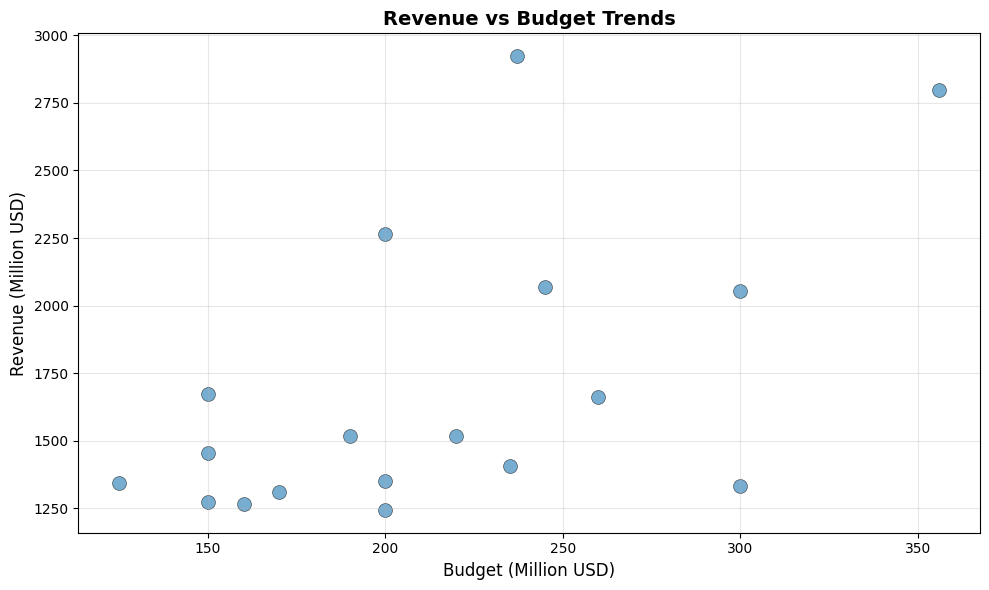

In [23]:
plot_revenue_vs_budget(movies_df)

**Observation:**
Positive correlation between budget and revenue. Higher budgets generally lead to higher revenues, but the relationship is not perfectly linear.


### 2. ROI Distribution by Genre

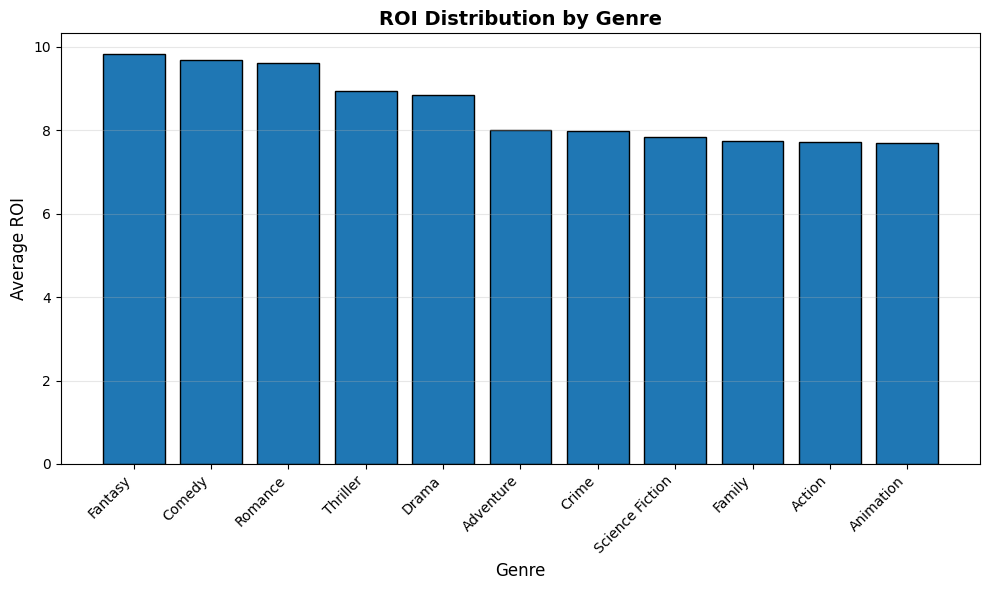

In [24]:
plot_roi_by_genre(movies_df)

**Observation:**
Fantasy, Comedy, and Romance genres lead in ROI, while Action and Animation rank lower.

### 3. Popularity vs. Rating

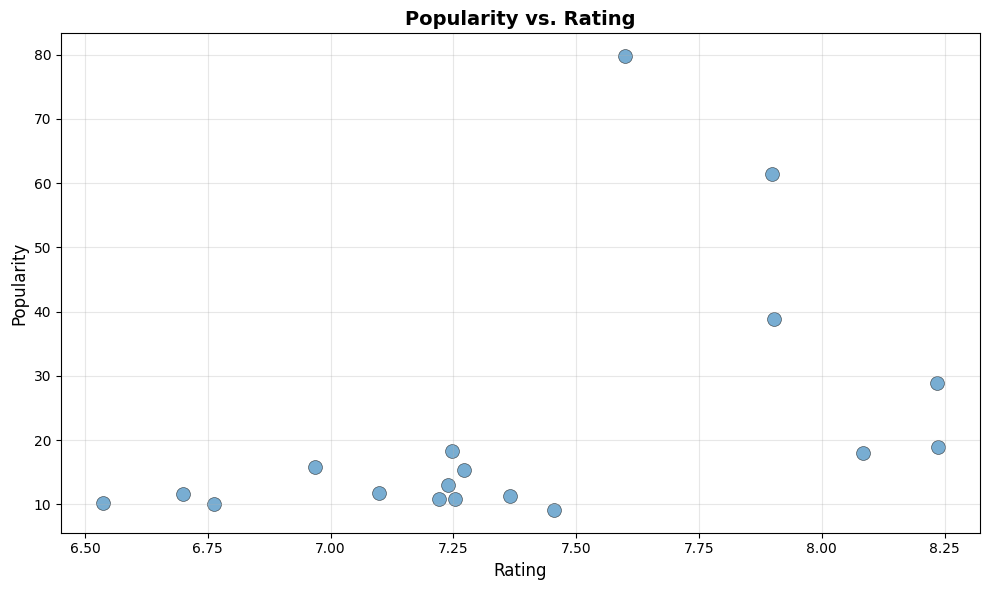

In [25]:
plot_popularity_vs_rating(movies_df)

**Observation:**
There is no strong linear correlation between popularity and rating. Movies with higher ratings (above 7.8) can have both low and very high popularity scores.

### 4. Yearly Trends in Box Office Performance

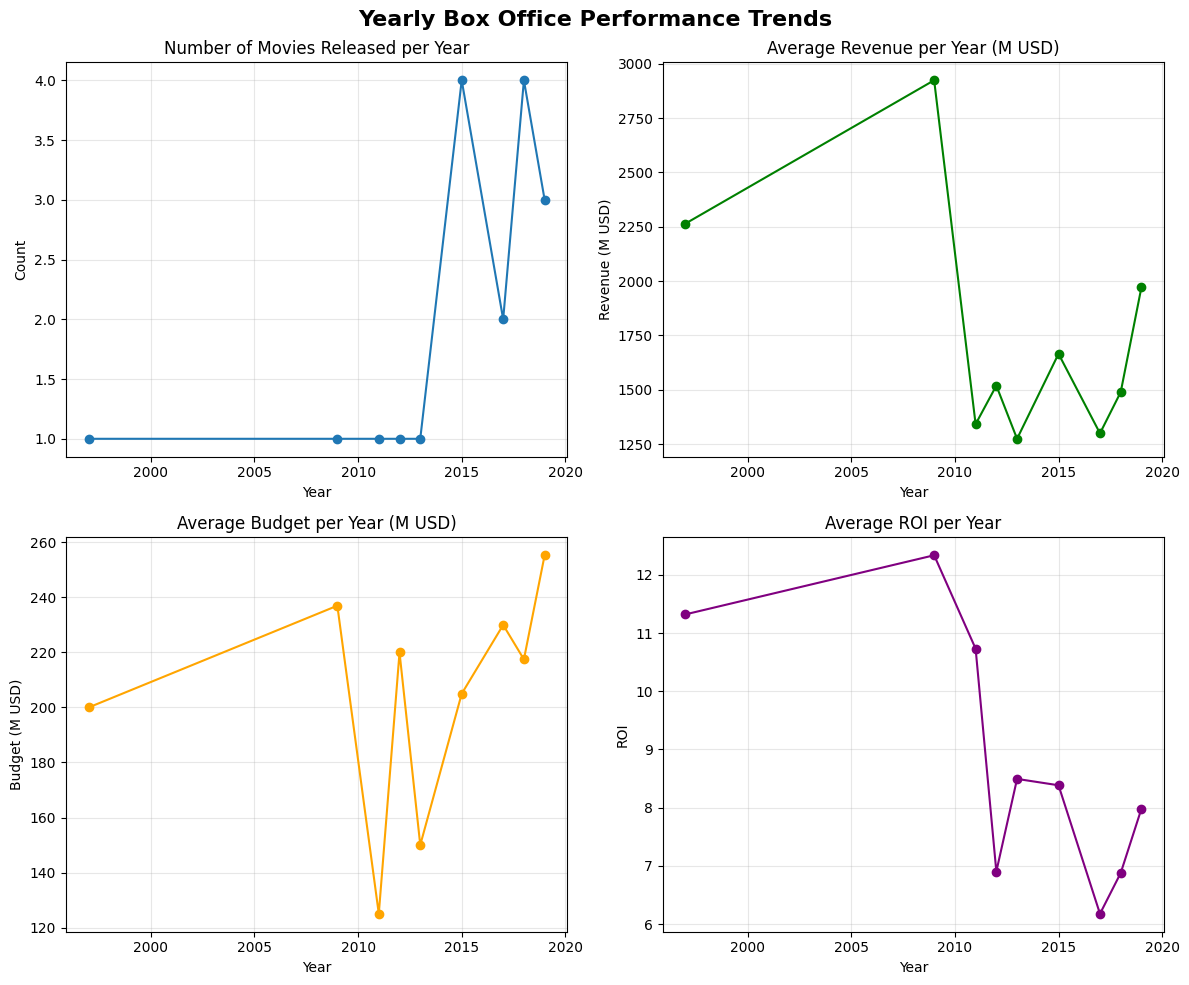

In [26]:
plot_yearly_trends(movies_df)

**Observation:**
- Movie Count: Sharp increase in releases post-2010, followed by fluctuations.
- Revenue: Peaks early, then declines around 2012–2015, possibly due to market saturation or streaming disruption.
- Budget: Increasing trend, with volatility—suggesting rising production costs.
- ROI: Declining trend after 2010, indicating reduced profitability despite higher budgets.

### 5. Franchise vs. Standalone Success Comparison

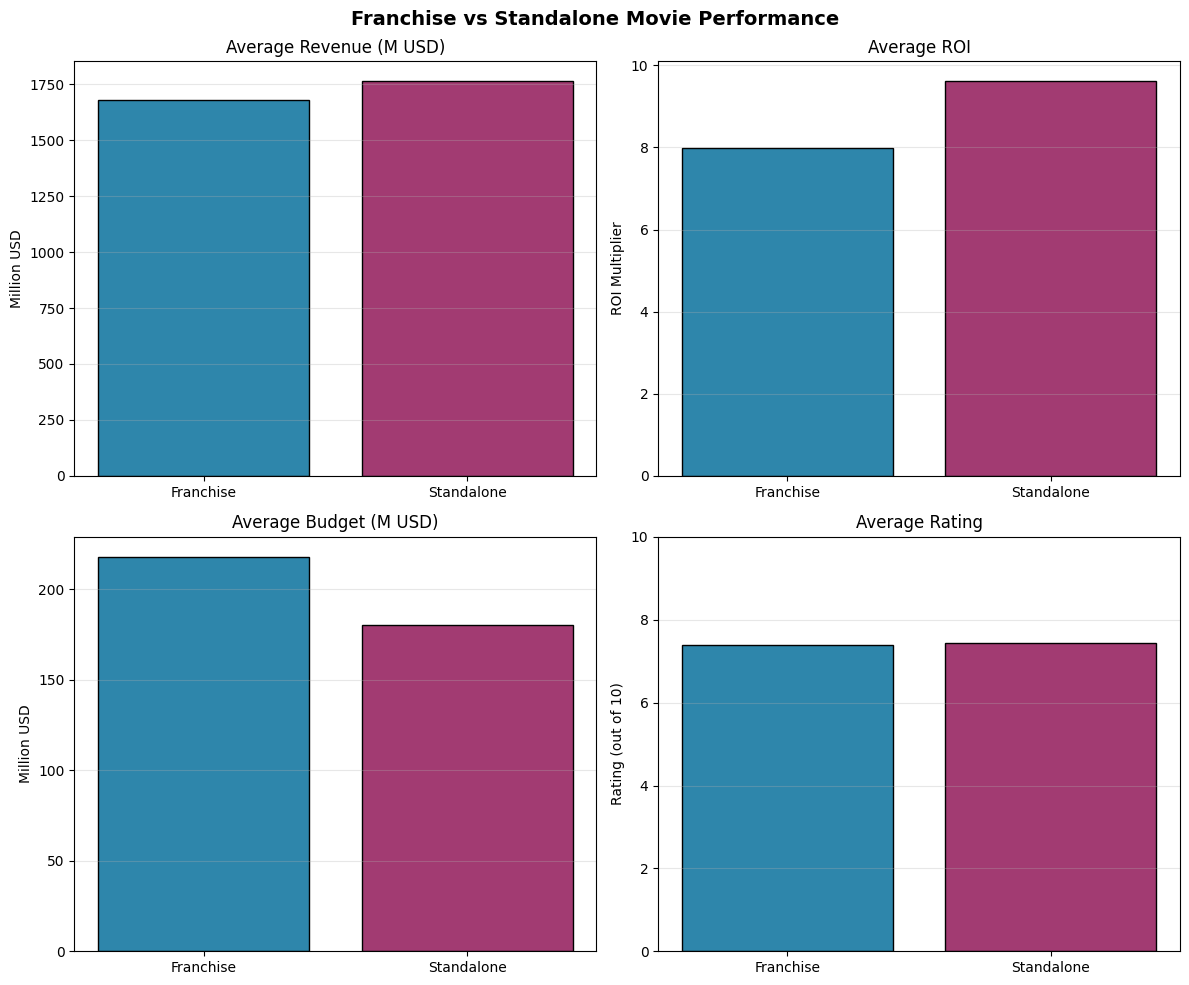

In [27]:
plot_franchise_comparison(movies_df)

**Observation:**
- Revenue: Standalone movies slightly outperform franchises in average revenue.
- ROI: Standalone movies have a higher ROI, meaning they generate more return per dollar spent.
- Budget: Franchises have significantly higher budgets, which increases financial risk.
- Rating: Ratings are nearly identical, suggesting audience perception is not strongly tied to franchise status.